<a href="https://colab.research.google.com/github/btcnhung1299/tf-practice/blob/master/TS_SunspotForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv

--2020-09-29 07:28:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.002s  

2020-09-29 07:28:39 (31.6 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [2]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("Sunspots.csv", index_col=0)
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = df["Monthly Mean Total Sunspot Number"].values.reshape(-1, 1)
data = scaler.fit_transform(data)

<Figure size 360x432 with 0 Axes>

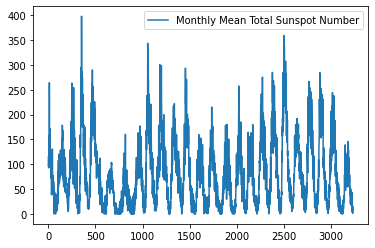

In [5]:
fig = plt.figure(figsize=(5, 6));
df.plot();

### Multi-output forecasting w. single step model

Predict multiple next values at once.

In [6]:
BUFFER_SIZE = 2048
WINDOW_SIZE = 60

samples = tf.data.Dataset.from_tensor_slices(data)
samples = samples.window(size=WINDOW_SIZE + 1, shift=1, drop_remainder=True).flat_map(lambda w : w.batch(WINDOW_SIZE + 1))
samples = samples.map(lambda x : (tf.expand_dims(x[:-1], axis=-1), x[1:]))
samples = samples.shuffle(BUFFER_SIZE)

In [7]:
BATCH_SIZE = 64

test_size = 0.2
num_samples = sum(1 for x in samples)
num_train_samples = int((1 - test_size) * num_samples)
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_samples - num_train_samples)
ds_train = samples.take(num_train_samples).batch(BATCH_SIZE)
ds_val = samples.skip(num_train_samples).batch(BATCH_SIZE)

Number of training samples: 2540
Number of validation samples: 635


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense

In [9]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[WINDOW_SIZE, 1]))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))

In [10]:
model.compile(optimizer="rmsprop", loss="huber", metrics=["mae", "mse"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 32)            192       
_________________________________________________________________
lstm (LSTM)                  (None, 60, 128)           82432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 64)            49408     
_________________________________________________________________
dense (Dense)                (None, 60, 32)            2080      
_________________________________________________________________
dense_1 (Dense)              (None, 60, 16)            528       
_________________________________________________________________
dense_2 (Dense)              (None, 60, 1)             17        
Total params: 134,657
Trainable params: 134,657
Non-trainable params: 0
__________________________________________________

In [11]:
model.fit(ds_train, epochs=50, validation_data=ds_val);

Epoch 1/50
40/40 [==============================] - 3s 82ms/step - loss: 0.0075 - mae: 0.0851 - mse: 0.0150 - val_loss: 0.0036 - val_mae: 0.0581 - val_mse: 0.0072
Epoch 2/50
40/40 [==============================] - 2s 53ms/step - loss: 0.0036 - mae: 0.0600 - mse: 0.0071 - val_loss: 0.0036 - val_mae: 0.0592 - val_mse: 0.0072
Epoch 3/50
40/40 [==============================] - 2s 59ms/step - loss: 0.0030 - mae: 0.0557 - mse: 0.0061 - val_loss: 0.0026 - val_mae: 0.0533 - val_mse: 0.0052
Epoch 4/50
40/40 [==============================] - 2s 61ms/step - loss: 0.0027 - mae: 0.0528 - mse: 0.0054 - val_loss: 0.0022 - val_mae: 0.0477 - val_mse: 0.0044
Epoch 5/50
40/40 [==============================] - 2s 61ms/step - loss: 0.0025 - mae: 0.0514 - mse: 0.0051 - val_loss: 0.0021 - val_mae: 0.0483 - val_mse: 0.0042
Epoch 6/50
40/40 [==============================] - 2s 60ms/step - loss: 0.0023 - mae: 0.0491 - mse: 0.0046 - val_loss: 0.0020 - val_mae: 0.0470 - val_mse: 0.0041
Epoch 7/50
40/40 [====